<a href="https://colab.research.google.com/github/andyposbe/colabfold-batch-processor/blob/main/ColabFold_BATCH_Score_Extractor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# colabfold-batch-processor: ColabFold BATCH Score Extractor

**Author:** Andres Posbeyikian
**Date:** August 27, 2023

---

## Description

This Google Colab notebook recieves a Google Drive directory where results from [ColabFold BATCH](https://colab.research.google.com/github/sokrypton/ColabFold/blob/main/batch/AlphaFold2_batch.ipynb) were saved, and reads .json files of highest ranked models to generate an analysis. For details, and to cite this tool, refer to this Zenodo: [ ].


### **Usage**

The `mode` must be specified depending on whether it was a `monomer` or `multimer` run,  to extract either pTM and max_pae, or pTM, ipTM and calculate model confidence (0.2 pTM + 0.8 ipTM), respectively.

The resulting analysis and figures are displayed and then saved as a table (.xlsx), interactive graph (.html) and static graph (.png and .svg) in the `Analyis` subdirectory, generated next to the `input` directory.

---

In [2]:
#@title Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#@title Import libraries
from pathlib import Path
import glob
import os
import io
import json
import scipy
from google.colab import files
import numpy as np
import numpy
import json
import pandas as pd
import seaborn as sns
import openpyxl
import matplotlib.pyplot as plt
import matplotlib
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.subplots as sp
import plotly.express as px

In [15]:
#@title Set jobname and input directory
#@markdown (Remove '/' at the end of the directory)

Mode = 'Multimer' # @param ["Monomer", "Multimer"]
jobname = "AvrPto"#@param {type:"string"}
input_dir = '/content/drive/MyDrive/AF2/LG/Combinations/AVRPto/output' #@param {type:"string"}

In [16]:
#@title Extraction of confidence scores ( < 5 minutes )
# We make a list of the contents of the directory, filtering to only keep files that end with .json
json_files = []

for file in glob.glob(input_dir+'/*.json'):
  json_files.append(file)

#Making the dataframe
scores_list = []

for result in json_files:
    if "rank_001" in result:
            json_file_highest_ranking_model = result
    else:
        continue

    pre_ID = result.split(input_dir.split('/')[-1]+'/')[1]
    ID = pre_ID.split('_unrelaxed')[0]
    scores = json.loads(Path(json_file_highest_ranking_model).read_text())
    pTM = scores["ptm"]
    if Mode == 'Monomer':
      max_pae = scores["max_pae"]
      scores_list.append((ID,pTM,max_pae))

    if Mode == 'Multimer':
      ipTM = scores["iptm"]
      scores_list.append((ID,pTM,ipTM))

if Mode == 'Monomer':
  df = pd.DataFrame(data=scores_list,columns = ["ID", "pTM","max_pae"] )
  df = df.sort_values(by=['pTM'],ascending=False)

if Mode == 'Multimer':
  df = pd.DataFrame(data=scores_list,columns = ["ID", "pTM","ipTM"] )
  df['Model confidence'] = 0.8*df['ipTM']+0.2*df['pTM']
  df = df.sort_values(by=['Model confidence'],ascending=False)

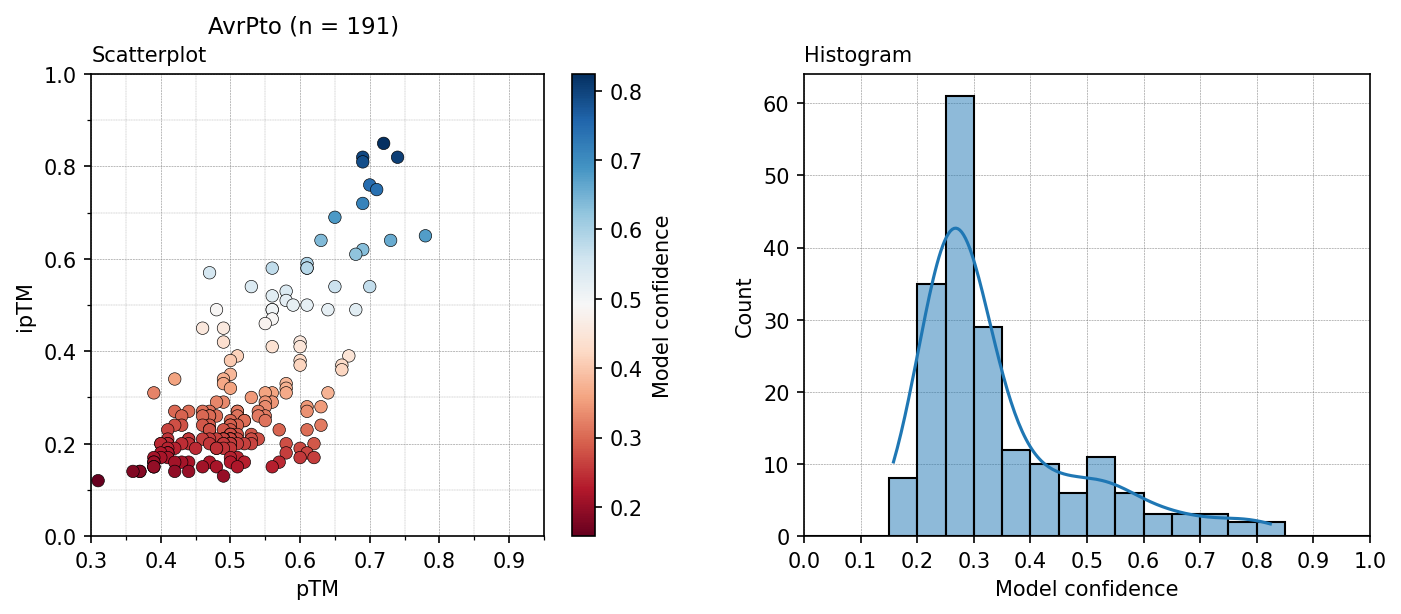

In [17]:
#@title Static plots

from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

if Mode == 'Monomer':

  ## Creating Figure
  fig, ax = plt.subplots(1, 2, figsize=(11,4), dpi=150)

  #Adding title and sub-titles
  ax[0].set_title('Histogram pTM scores', loc='left',fontsize=10)
  ax[1].set_title('Histogram max PAE score',loc='left',fontsize=10)
  plt.rc('axes', axisbelow=True)
  #fig.tight_layout(pad=3.5) #This can be played around with. Space between graphs

  ##Plot 1, Scatterplot
  #sns.scatterplot(ax=ax[0],data=df, x=df['pTM'], y=df['ipTM'], hue=df['Model confidence'], palette='RdBu') #Another option, graph using SEABORN
  sns.histplot(ax=ax[0], data=df, x=df['pTM'],kde=True,binwidth=0.05, binrange=(0,1))


  #Adding axis labels
  ax[0].set_xlabel('pTM')
  ax[0].set_ylabel('Count')

  #Setting axis limits,ticks and grids
  ax[0].set_xlim(0.1, 0.9)
  ax[0].set_xticks(np.arange(0, 1.1, step=0.1))
  ax[0].grid(color = 'grey', linestyle = '--', linewidth = 0.25)
  ax[0].xaxis.grid(True, which='minor',color = 'grey', linestyle = '--', linewidth = 0.15)
  ax[0].yaxis.grid(True, which='minor',color = 'grey', linestyle = '--', linewidth = 0.15)
  ax[0].xaxis.set_major_locator(MultipleLocator(0.1))
  ax[0].xaxis.set_minor_locator(MultipleLocator(0.05))
  ax[0].yaxis.set_major_locator(MultipleLocator(5))
  ax[0].yaxis.set_minor_locator(MultipleLocator(1))

  ##Plot 2, Histogram
  sns.histplot(ax=ax[1],data=df, x=df['max_pae'],kde=True)#,binwidth=0.05, binrange=(0,1))

  #Setting axis limits,ticks and grids
  #ax[1].set_xlim(0.1, 0.9)
  #ax[1].set_xticks(np.arange(0, 1.1, step=0.1))
  ax[1].grid(color = 'grey', linestyle = '--', linewidth = 0.25)
  fig.suptitle(jobname+' (n = '+str(len(df['ID']))+')',x=0.195,fontsize=11)

  #plt.tight_layout()
  fig.subplots_adjust(wspace=0.26,hspace=0.5)
  plt.savefig(jobname+'_figures.svg')
  plt.savefig(jobname+'_figures.png')


if Mode == 'Multimer':

  ## Creating Figure
  fig, ax = plt.subplots(1, 2, figsize=(11,4), dpi=150)

  #Adding title and sub-titles
  ax[0].set_title('Scatterplot', loc='left',fontsize=10)
  ax[1].set_title('Histogram',loc='left',fontsize=10)
  plt.rc('axes', axisbelow=True)
  #fig.tight_layout(pad=3.5) #This can be played around with. Space between graphs

  ##Plot 1, Scatterplot
  #sns.scatterplot(ax=ax[0],data=df, x=df['pTM'], y=df['ipTM'], hue=df['Model confidence'], palette='RdBu') #Another option, graph using SEABORN
  im = ax[0].scatter(x=df['pTM'], y=df['ipTM'],c=df['Model confidence'], cmap='RdBu',edgecolors = 'black',linewidths=0.3)

  #Adding colorbar
  cbar = fig.colorbar(im, ax=ax[0])
  cbar.ax.get_yaxis().labelpad = 5
  cbar.ax.set_ylabel('Model confidence', rotation=-270)

  #Adding axis labels
  ax[0].set_xlabel('pTM')
  ax[0].set_ylabel('ipTM')

  #Setting axis limits,ticks and grids
  ax[0].set_ylim(0, 1)
  ax[0].set_xlim(0.3, 0.95)
  ax[0].set_xticks(np.arange(0.3, 0.8, step=0.1))
  ax[0].grid(color = 'grey', linestyle = '--', linewidth = 0.25)
  ax[0].xaxis.grid(True, which='minor',color = 'grey', linestyle = '--', linewidth = 0.15)
  ax[0].yaxis.grid(True, which='minor',color = 'grey', linestyle = '--', linewidth = 0.15)
  ax[0].xaxis.set_major_locator(MultipleLocator(0.1))
  ax[0].xaxis.set_minor_locator(MultipleLocator(0.05))
  ax[0].yaxis.set_major_locator(MultipleLocator(0.2))
  ax[0].yaxis.set_minor_locator(MultipleLocator(0.1))

  ##Plot 2, Histogram
  sns.histplot(ax=ax[1],data=df, x=df['Model confidence'],kde=True,binwidth=0.05, binrange=(0,1))

  #Setting axis limits,ticks and grids
  ax[1].set_xlim(0.1, 0.9)
  ax[1].set_xticks(np.arange(0, 1.1, step=0.1))
  ax[1].grid(color = 'grey', linestyle = '--', linewidth = 0.25)
  fig.suptitle(jobname+' (n = '+str(len(df['ID']))+')',x=0.254,fontsize=11)

  #plt.tight_layout()
  fig.subplots_adjust(wspace=0.26,hspace=0.5)
  #Final figure saved
  plt.savefig(jobname+'_figures.svg')
  plt.savefig(jobname+'_figures.png')


In [18]:
#@title Interactive plots

if Mode == 'Monomer':

  # Create subplots with 1 row and 2 columns
  fig = make_subplots(rows=1, cols=2, subplot_titles=['Histogram of pTM', 'Histogram of max_PAE'])

  # Add the first histogram for 'pTM'
  histogram1 = go.Histogram(x=df['pTM'], nbinsx=20)
  fig.add_trace(histogram1, row=1, col=1)

  # Add the second histogram for 'max_PAE'
  histogram2 = go.Histogram(x=df['max_pae'], nbinsx=10)
  fig.add_trace(histogram2, row=1, col=2)

  # Update layout
  fig.update_layout(title= jobname+' (n = '+str(len(df['ID']))+')', showlegend=False)
  fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='lightgray')
  fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='lightgray')

  # Add lines to the bars
  fig.update_traces(marker_line_width=1, marker_line_color='white')
  # Show the figure
  fig.show()

if Mode == 'Multimer':
  # Creating a subplot figure
  fig = sp.make_subplots(rows=1, cols=2, subplot_titles=("Scatterplot", "Histogram"))

  # Plot 1: Scatterplot
  scatter_trace = go.Scatter(
      x=df['pTM'],
      y=df['ipTM'],
      text=df['ID'],  # ID as hover text
      mode='markers',
      marker=dict(
          size=8,
          color=df['Model confidence'],
          colorscale='RdBu',
          showscale=True,
          line=dict(color='black', width=0.3),
      ),
      hovertemplate='ID: %{text}<br>pTM: %{x}<br>ipTM: %{y}<br>Model confidence: %{marker.color}<extra></extra>'
  )
  fig.add_trace(scatter_trace, row=1, col=1)

  # Plot 2: Histogram
  histogram_trace = px.histogram(
      df,
      x='Model confidence',
      nbins=20,
      opacity=0.7,
      color_discrete_sequence=['blue'],  # You can change the color here
  )
  fig.add_trace(histogram_trace['data'][0], row=1, col=2)

  # Update layout for Scatterplot
  fig.update_xaxes(title_text='pTM', range=[0.3, 0.95], row=1, col=1)
  fig.update_yaxes(title_text='ipTM', range=[0, 1], row=1, col=1)
  fig.update_coloraxes(colorbar=dict(yanchor="top", y=0.95, title="Model confidence"), row=1, col=1)

  # Update layout for Histogram
  fig.update_xaxes(title_text='Model confidence', range=[0, 1], row=1, col=2)
  fig.update_yaxes(title_text='Frequency', row=1, col=2)

  # Update layout for the entire figure
  fig.update_layout(
    title={'text': jobname + ' (n = ' + str(len(df['ID'])) + ')', 'x': 0.5},
    font=dict(size=11),
    margin=dict(t=50, b=30),  # Adjust top and bottom margin
    showlegend=False,
    coloraxis_showscale=False,
    height=500,
    width=1000,  # Adjust width as needed
)

  # Show the interactive plot
  fig.write_html(jobname+"_interactive.html")
  fig.show()


In [19]:
#@title Quick view of the table
#@markdown - `Monomer` data sorted by descending **pTM** scores.
#@markdown - `Multimer` data sorted by descending **Model confidence** scores.
pd.set_option('max_colwidth', None)
df

,ID,pTM,ipTM,Model confidence
152,Eff_AVRPtoID_117_OTHER_Zm-Ia453_scores_rank_001_alphafold2_multimer_v3_model_2_seed_000.json,0.72,0.85,0.824
79,Eff_AVRPtoID_301_OTHER_Zd-Momo_scores_rank_001_alphafold2_multimer_v3_model_1_seed_000.json,0.74,0.82,0.804
125,Eff_AVRPtoID_223_TRANSPOSON_Zd-Gigi_scores_rank_001_alphafold2_multimer_v3_model_4_seed_000.json,0.69,0.82,0.794
124,Eff_AVRPtoID_033_TRANSPOSON_Zm-CML69_scores_rank_001_alphafold2_multimer_v3_model_4_seed_000.json,0.69,0.81,0.786
57,Eff_AVRPtoID_094_TRANSPOSON_Zm-SK_scores_rank_001_alphafold2_multimer_v3_model_5_seed_000.json,0.70,0.76,0.748
...,...,...,...,...
56,Eff_AVRPtoID_286_PKin_Zm-B73_scores_rank_001_alphafold2_multimer_v3_model_4_seed_000.json,0.42,0.14,0.196
99,Eff_AVRPtoID_136_OTHER_Zm-Ia453_scores_rank_001_alphafold2_multimer_v3_model_3_seed_000.json,0.37,0.14,0.186
102,Eff_AVRPtoID_133_OTHER_Zm-Ia453_scores_rank_001_alphafold2_multimer_v3_model_3_seed_000.json,0.37,0.14,0.186
26,Eff_AVRPtoID_072_PKin_Zm-Ms71_scores_rank_001_alphafold2_multimer_v3_model_2_seed_000.json,0.36,0.14,0.184


In [20]:
#@title Save analysis to /MyDrive/ ... /[input_dir]/Analysis
import os

# Specify the path to the desired directory
save_path = input_dir.strip('/output') + '/'
save_path = save_path.strip('content')
save_path = save_path.replace(save_path[0], "", 1) + '/Analysis'

# Create the "Analysis" directory if it doesn't exist
os.makedirs(save_path, exist_ok=True)

filename_dataframe = jobname + '_scores.xlsx'
filename_figures1 = jobname + '_figures.svg'
filename_figures2 = jobname + '_figures.png'
filename_interactive = jobname+ '_interactive.html'

# Save the DataFrame to an Excel file
df.to_excel(os.path.join(save_path, filename_dataframe), index=False)

!cp {filename_figures1} {save_path}
!cp {filename_figures2} {save_path}
!cp {filename_interactive} {save_path}


------